# Visualization

In [33]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Data Overview

Tables in database:


,name
0,Country
1,League
2,Match
3,Player
4,Player_Attributes
5,Team
6,Team_Attributes
7,sqlite_sequence


match rows: 25979
player rows: 11060
player_attr rows: 183978


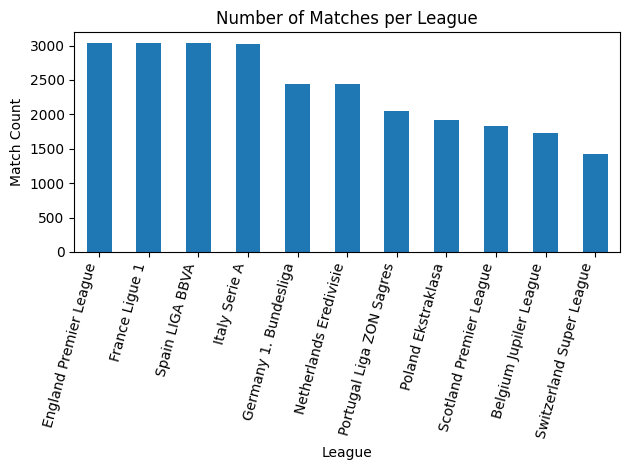

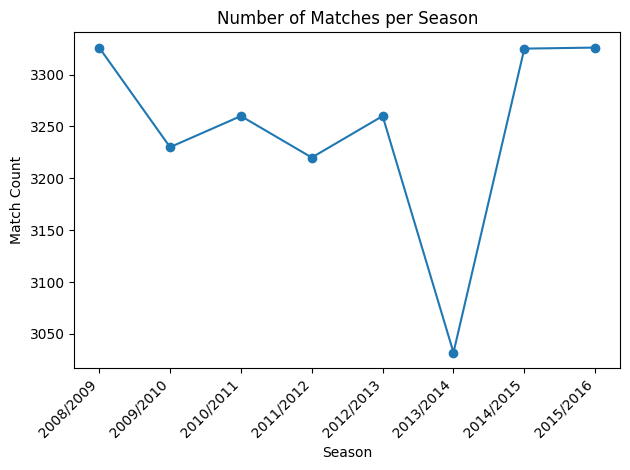

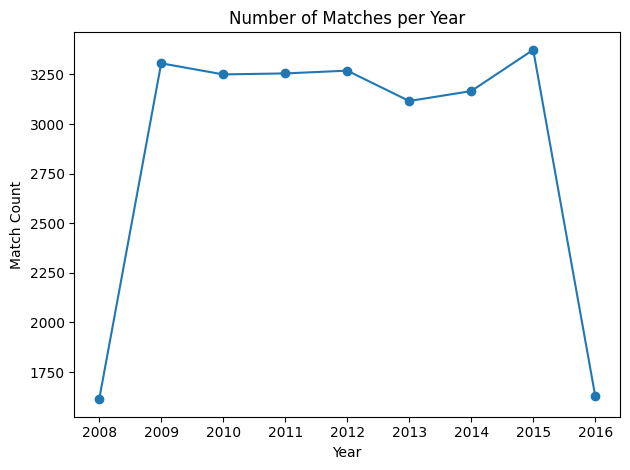

Reference date for age calculation: 2016-05-25 00:00:00


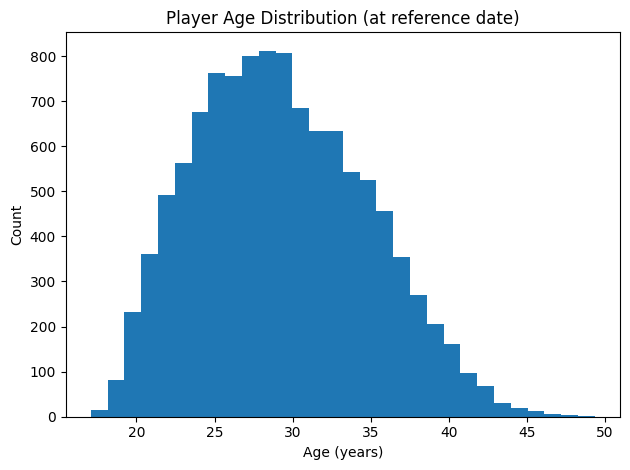

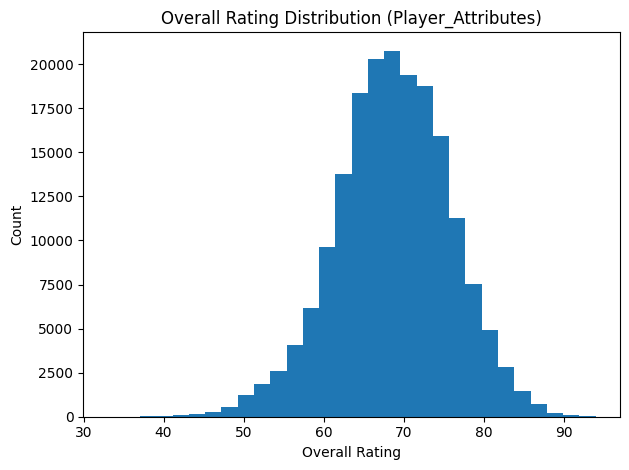

,metric,value
0,num_matches,25979
1,num_leagues,11
2,num_countries,11
3,num_players,11060
4,num_player_attr_rows,183978
5,match_date_min,2008-07-18 00:00:00
6,match_date_max,2016-05-25 00:00:00


In [35]:
DB_PATH = r"C:\Users\asus\Documents\ECE143\Group_project\archive\database.sqlite"

# Connect
conn = sqlite3.connect(DB_PATH)

tables = pd.read_sql_query(
    "SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;",
    conn
)
print("Tables in database:")
display(tables)

# Load minimal tables needed
league = pd.read_sql_query("SELECT id, name, country_id FROM League;", conn)
country = pd.read_sql_query("SELECT id, name FROM Country;", conn)
match = pd.read_sql_query("""
    SELECT id, country_id, league_id, season, date,
           home_team_api_id, away_team_api_id,
           home_team_goal, away_team_goal
    FROM Match;
""", conn)

player = pd.read_sql_query("SELECT id, player_api_id, player_name, birthday FROM Player;", conn)

player_attr = pd.read_sql_query("""
    SELECT player_api_id, date, overall_rating
    FROM Player_Attributes;
""", conn)

# Basic cleaning
# Match date -> datetime
match["date"] = pd.to_datetime(match["date"], errors="coerce")

# Player birthday -> datetime
player["birthday"] = pd.to_datetime(player["birthday"], errors="coerce")

# Player_Attributes date -> datetime
player_attr["date"] = pd.to_datetime(player_attr["date"], errors="coerce")

# Quick checks
print("match rows:", len(match))
print("player rows:", len(player))
print("player_attr rows:", len(player_attr))


# Plot 1: Matches per League (League distribution)
# Join match -> league -> country for readable labels
match_league = match.merge(league, left_on="league_id", right_on="id", how="left", suffixes=("", "_league"))
match_league = match_league.merge(country, left_on="country_id", right_on="id", how="left", suffixes=("", "_country"))

# Count matches by league name
league_counts = (
    match_league.groupby("name")["id"]
    .count()
    .sort_values(ascending=False)
)

plt.figure()
league_counts.plot(kind="bar")
plt.title("Number of Matches per League")
plt.xlabel("League")
plt.ylabel("Match Count")
plt.xticks(rotation=75, ha="right")
plt.tight_layout()
plt.show()


# Plot 2: Matches per Season (Season distribution)
season_counts = (
    match.dropna(subset=["season"])
    .groupby("season")["id"]
    .count()
    .sort_index()
)

plt.figure()
season_counts.plot(kind="line", marker="o")
plt.title("Number of Matches per Season")
plt.xlabel("Season")
plt.ylabel("Match Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


# Plot 3: Matches per Year
match["year"] = match["date"].dt.year
year_counts = (
    match.dropna(subset=["year"])
    .groupby("year")["id"]
    .count()
    .sort_index()
)

plt.figure()
year_counts.plot(kind="line", marker="o")
plt.title("Number of Matches per Year")
plt.xlabel("Year")
plt.ylabel("Match Count")
plt.tight_layout()
plt.show()


# Plot 4: Player Age Distribution
# Use a reference date
ref_date = match["date"].max()
print("Reference date for age calculation:", ref_date)

player_age = player.copy()
player_age = player_age.dropna(subset=["birthday"])
player_age["age_years"] = (ref_date - player_age["birthday"]).dt.days / 365.25
player_age = player_age[(player_age["age_years"] > 10) & (player_age["age_years"] < 60)]  # basic sanity bounds

plt.figure()
plt.hist(player_age["age_years"], bins=30)
plt.title("Player Age Distribution (at reference date)")
plt.xlabel("Age (years)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


# Plot 5: Overall Rating Distribution
rating = player_attr.dropna(subset=["overall_rating"]).copy()
rating = rating[(rating["overall_rating"] >= 1) & (rating["overall_rating"] <= 100)]  # typical rating range

plt.figure()
plt.hist(rating["overall_rating"], bins=30)
plt.title("Overall Rating Distribution (Player_Attributes)")
plt.xlabel("Overall Rating")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Summary stats table
summary = pd.DataFrame({
    "metric": [
        "num_matches", "num_leagues", "num_countries",
        "num_players", "num_player_attr_rows",
        "match_date_min", "match_date_max"
    ],
    "value": [
        len(match),
        league["id"].nunique(),
        country["id"].nunique(),
        player["player_api_id"].nunique(),
        len(player_attr),
        match["date"].min(),
        match["date"].max()
    ]
})

display(summary)

# close connection
conn.close()